Trainning The Cannon on ages and see bias/scatter using 10-fold cross-validation. Also look at red clump contamination percentage.

In [4]:
%matplotlib inline

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from HeaderP import *
plt.rcParams.keys()
plt.rc('font', family='serif')
params = {
   'axes.labelsize': 30,
   'axes.linewidth': 1.5,
   'legend.fontsize': 25,
   'legend.frameon': False,
   'lines.linewidth': 2,
   'xtick.direction': 'in',
   'xtick.labelsize': 25,
   'xtick.major.bottom': True,
   'xtick.major.pad': 10,
   'xtick.major.size': 10,
   'xtick.major.width': 1,
   'xtick.minor.bottom': True,
   'xtick.minor.pad': 3.5,
   'xtick.minor.size': 5,
   'xtick.minor.top': True,
   'xtick.minor.visible': True,
   'xtick.minor.width': 1,
   'xtick.top': True,
   'ytick.direction': 'in',
   'ytick.labelsize': 25,
   'ytick.major.pad': 10,
   'ytick.major.size': 10,
   'ytick.major.width': 1,
   'ytick.minor.pad': 3.5,
   'ytick.minor.size': 5,
   'ytick.minor.visible': True,
   'ytick.minor.width': 1,
   'ytick.right': True,
   'figure.figsize': [10,10], # instead of 4.5, 4.5
   'savefig.format': 'eps',
   }
plt.rcParams.update(params)

def fitpoints(x,y):
    z = np.polyfit(x,y,1)
    p = np.poly1d(z)
    return p

import matplotlib.gridspec as gridspec
def diagnostics_1to1(ds, figname="1to1_label"):
        """ Plots survey labels vs. training labels, color-coded by survey SNR """
        label_names = ds.get_plotting_labels()
        nlabels = len(label_names)
        print(nlabels)
        reference_labels = ds.test_label
        test_labels = ds.test_label_vals

        for i in range(nlabels):
            snr = ds.test_SNR
            name = label_names[i]
            orig = reference_labels[:,i]
            cannon = test_labels[:,i]
            
            '''
            m1=cannon>-500
            m2=orig>-500
            m=m1&m2
            
            orig, cannon, snr=orig[m],cannon[m],snr[m]
            '''
            # calculate bias and scatter
            scatter = np.round(np.std(orig-cannon),5)
            bias  = np.round(np.mean(orig-cannon),5)

            low = np.minimum(min(orig), min(cannon))
            high = np.maximum(max(orig), max(cannon))

            fig = plt.figure(figsize=(10,6))
            gs = gridspec.GridSpec(1,2,width_ratios=[2,1], wspace=0.3)
            ax1 = plt.subplot(gs[0])
            ax2 = plt.subplot(gs[1])
            ax1.plot([low, high], [low, high], 'k-', linewidth=2.0, label="x=y")
            ax1.set_xlim(low, high)
            ax1.set_ylim(low, high)
            ax1.legend(fontsize=14, loc='lower right')

            pl = ax1.scatter(orig, cannon, marker='x', c=snr,
                    vmin=50, vmax=200, alpha=0.7)
            cb = plt.colorbar(pl, ax=ax1, orientation='horizontal')
            cb.set_label('SNR from Test Set', fontsize=12)
            textstr = 'Scatter: %s \nBias: %s' %(scatter, bias)
            ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes,
                    fontsize=14, verticalalignment='top')
            ax1.tick_params(axis='x', labelsize=14)
            ax1.tick_params(axis='y', labelsize=14)
            ax1.set_xlabel("Reference Value", fontsize=14)
            ax1.set_ylabel("Cannon Test Value", fontsize=14)
            ax1.set_title("1-1 Plot of Label " + r"$%s$" % name)
            diff = cannon-orig
            npoints = len(diff)
            mu = np.mean(diff)
            sig = np.std(diff)
            #ax2.hist(diff, orientation='horizontal')
            ax2.hist(diff, range=[-3*sig,3*sig], color='k', bins=int(np.sqrt(npoints)),
                    orientation='horizontal', alpha=0.3, histtype='stepfilled')
            ax2.tick_params(axis='x', labelsize=14)
            ax2.tick_params(axis='y', labelsize=14)
            ax2.set_xlabel("Count", fontsize=14)
            ax2.set_ylabel("Difference", fontsize=14)
            ax2.axhline(y=0, c='k', lw=3, label='Difference=0')
            ax2.set_title("Training Versus Test Labels for $%s$" %name,
                    fontsize=14)
            ax2.legend(fontsize=14)
            figname_full = "%s_%s.png" %(figname, i)




In [5]:
import os
from astropy.io import fits as pyfits
def load_spectra(data_dir):
    """ Reads wavelength, flux, and flux uncertainty data from apogee fits files

    Parameters
    ----------
    data_dir: str
        Name of the directory containing all of the data files

    Returns
    -------
    wl: ndarray
        Rest-frame wavelength vector

    fluxes: ndarray
        Flux data values

    ivars: ndarray
        Inverse variance values corresponding to flux values
    """
    print("Loading spectra from directory %s" %data_dir)
    files = list(sorted([data_dir + "/" + filename
             for filename in os.listdir(data_dir) if filename.endswith('fits')]))
    nstars = len(files)  
    for jj, fits_file in enumerate(files):
        file_in = pyfits.open(fits_file)
        #print(file_in)
        flux = np.array(file_in[1].data)
        if jj == 0:
            npixels = len(flux)
            fluxes = np.zeros((nstars, npixels), dtype=float)
            ivars = np.zeros(fluxes.shape, dtype=float)
            start_wl = file_in[1].header['CRVAL1']
            diff_wl = file_in[1].header['CDELT1']
            val = diff_wl * (npixels) + start_wl
            wl_full_log = np.arange(start_wl,val, diff_wl)
            wl_full = [10 ** aval for aval in wl_full_log]
            wl = np.array(wl_full)
        flux_err = np.array((file_in[2].data))
        badpix = get_pixmask(flux, flux_err)
        ivar = np.zeros(npixels)
        ivar[~badpix] = 1. / flux_err[~badpix]**2
        fluxes[jj,:] = flux
        ivars[jj,:] = ivar
    # convert filenames to actual IDs
    names = np.array([f.split('r12-')[1].split('.fits')[0] for f in files])
    print("Spectra loaded")
    # make sure they are numpy arrays
    return np.array(names), np.array(wl), np.array(fluxes), np.array(ivars)

def get_pixmask(fluxes, flux_errs):
    """ Create and return a bad pixel mask for an APOGEE spectrum

    Bad pixels are defined as follows: fluxes or errors are not finite, or 
    reported errors are <= 0, or fluxes are 0

    Parameters
    ----------
    fluxes: ndarray
        Flux data values 

    flux_errs: ndarray
        Flux uncertainty data values 

    Returns
    -------
    mask: ndarray
        Bad pixel mask, value of True corresponds to bad pixels
    """
    bad_flux = np.logical_or(~np.isfinite(fluxes), fluxes == 0)
    bad_err = (~np.isfinite(flux_errs)) | (flux_errs <= 0)
    bad_pix = bad_err | bad_flux
    return bad_pix

period spacing and $\Delta \nu$ from https://ui.adsabs.harvard.edu/abs/2016yCat..35880087V/abstract

In [6]:
df_CM=pd.read_pickle('Vrard2016_CM.pkl')

Ages from https://ui.adsabs.harvard.edu/abs/2018ApJS..239...32P/abstract

In [7]:
df2=pd.read_table('AstroAges.csv',delimiter=',')
df2.columns

Index(['KIC', 'Nmax-A2Z', 'Dnu-A2Z', 'Nmax-CAN', 'Dnu-CAN', 'Nmax-COR',
       'Dnu-COR', 'Nmax-OCT', 'Dnu-OCT', 'Nmax-SYD', 'Dnu-SYD', 'KIC.1',
       '2MASS', 'Teff', 'FeH', 'AFe', 'Numax', 'Dnu', 'ES', 'Fdnu', 'M(cor)',
       's_M(cor)', 'R(cor)', 's_R(cor)', 'logg(seis)', 's_logg(seis)', 'Rho',
       's_Rho', 'LogAge', 'Av', 'Notes', 'AP-1', '_RA', '_DE'],
      dtype='object')

In [8]:
df_age=pd.merge(df_CM,df2[['KIC','LogAge']],left_on='KIC',right_on='KIC',how='inner')

In [9]:
#df_age['M'].hist()

In [10]:
# read in data and process

from TheCannon import apogee
tr_ID_r, wl_r, tr_flux_r, tr_ivar_r = load_spectra("Vrardstars")


Loading spectra from directory Vrardstars
Spectra loaded


# Select data

Starting: 2992 stars

Flagged: 2616 stars

SNR>100: 2480 stars

In [11]:
print(len(df_age))
df_age['FLAGREAD']=[i&2**23 for i in df_age.ASPCAPFLAG]

2992


In [12]:
df_age=df_age.loc[df_age['FLAGREAD']==0].reset_index(drop=True)

(2616, 9)


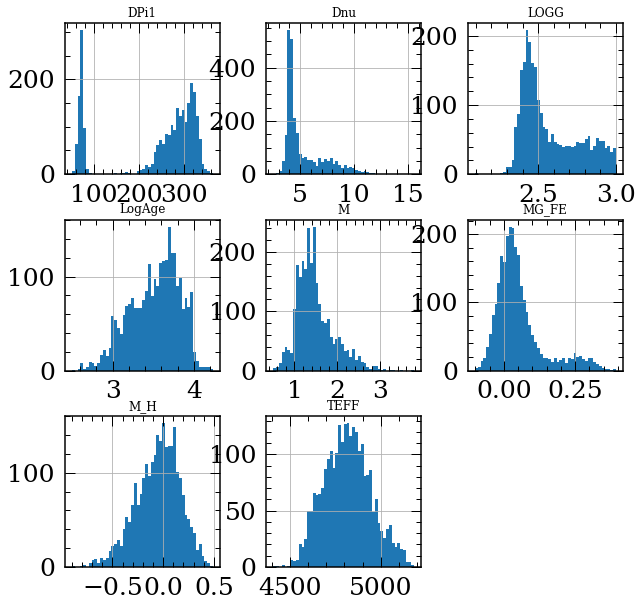

In [13]:
df_pick = df_age.loc[df_age['APOGEE_ID'].isin(tr_ID_r)].drop_duplicates(subset='APOGEE_ID',keep='first')[['M_H','TEFF','LOGG','MG_FE','DPi1','Dnu','APOGEE_ID','LogAge','M']].dropna()
m1 = df_pick['MG_FE']>-500
m2 = df_pick['M_H']>-1
m3 = df_pick['TEFF']>0
m4 = (df_pick['LOGG']<3) & (df_pick['LOGG']>2)

m=m1&m2&m3&m4
df_pick=df_pick[m]

df_pick.hist(bins=50)


print(np.shape(df_pick))


In [14]:

tr_ID_pick=df_pick['APOGEE_ID'].values

m=np.zeros(len(tr_ID_r),dtype='bool')
for i in range(len(m)):
    if tr_ID_r[i] in tr_ID_pick:
        m[i]=1

tr_ID, wl, tr_flux, tr_ivar = tr_ID_r[m], wl_r, tr_flux_r[m,:], tr_ivar_r[m,:]


In [15]:
tr_label=np.zeros((len(tr_ID),7))

for i in range((len(tr_ID))):
    #print(i)
    tr_label[i,:]=df_pick.loc[df_pick['APOGEE_ID']==tr_ID[i]][['M_H','TEFF','LOGG','MG_FE','DPi1','Dnu','LogAge']].values
               

In [16]:
print(len(tr_ID),np.shape(df_pick))

2616 (2616, 9)


In [17]:
np.shape(tr_label)

(2616, 7)

In [18]:
def _SNR(flux, ivar):
    """ Calculate the SNR of a spectrum, ignoring bad pixels

    Parameters
    ----------
    flux: numpy ndarray
        pixel intensities
    ivar: numpy ndarray
        inverse variances corresponding to flux

    Returns
    -------
    SNR: float
    """
    take = ivar > 0
    SNR = float(np.median(flux[take]*(ivar[take]**0.5)))
    return SNR  

In [19]:
#take = tr_ivar > 0
SNR = np.array([_SNR(*s) for s in zip(tr_flux, tr_ivar)])
    

In [20]:
len(SNR)

2616

In [21]:
m_snr=SNR>100

In [22]:
tr_ID, tr_flux, tr_ivar=tr_ID[m_snr],tr_flux[m_snr,:], tr_ivar[m_snr,:]

In [23]:
tr_label=tr_label[m_snr,:]

In [24]:
print(tr_ID.shape)
print(wl.shape)
print(tr_flux.shape)
print(tr_ivar.shape)
print(tr_label.shape)


(2480,)
(8575,)
(2480, 8575)
(2480, 8575)
(2480, 7)


# Attemp to check if rc ages are inaccurate

Text(0.5, 0, 'LogAge')

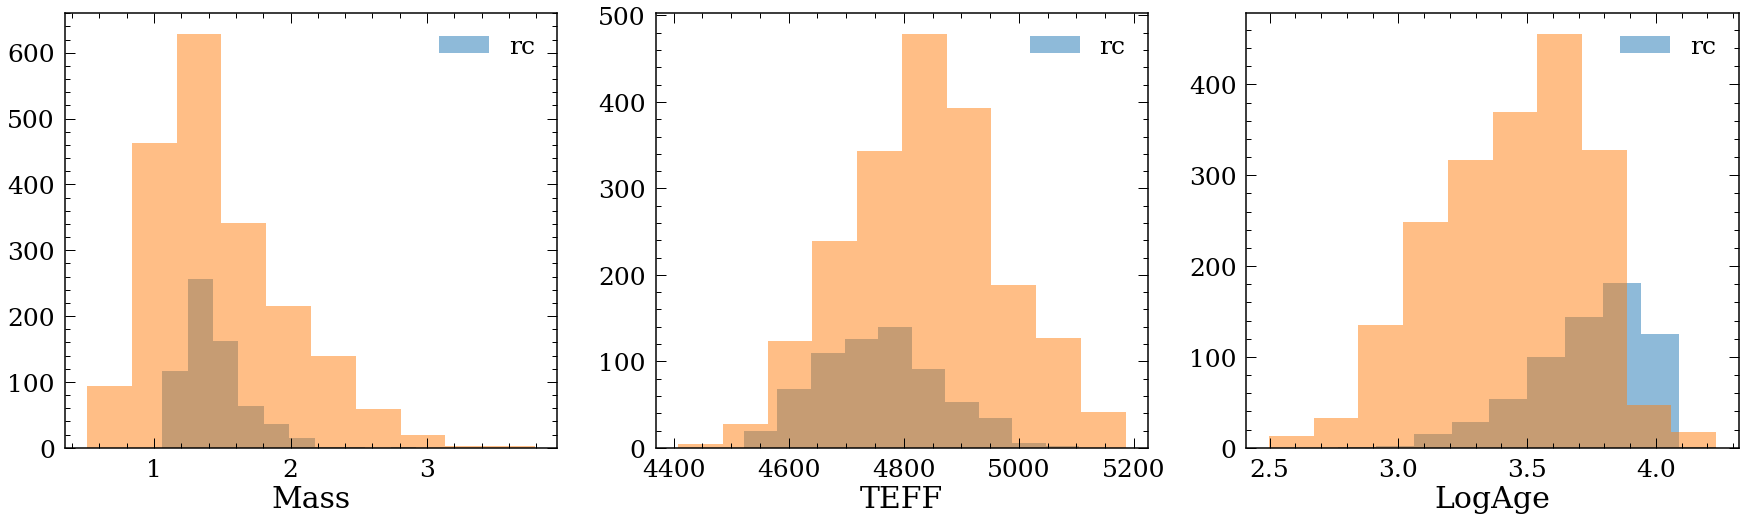

In [25]:
rc_check=df_pick['DPi1']<100
rc=df_pick[rc_check]
giant=df_pick[~rc_check]

masscut=2

plt.figure(figsize=(30,8))
plt.subplot(1,3,1)
plt.hist(rc['M'],alpha=0.5,label='rc')
plt.hist(giant['M'],alpha=0.5)
plt.legend()
plt.xlabel('Mass')

plt.subplot(1,3,2)
plt.hist(rc['TEFF'],alpha=0.5,label='rc')
plt.hist(giant['TEFF'],alpha=0.5)
plt.legend()
plt.xlabel('TEFF')

plt.subplot(1,3,3)
plt.hist(rc['LogAge'],alpha=0.5,label='rc')
plt.hist(giant['LogAge'],alpha=0.5)
plt.legend()
plt.xlabel('LogAge')

In [26]:
#plt.scatter(tr_flux[:,1000],tr_label[:,0],c=tr_ivar[:,1000])

# Train on 90% data and leave 10% out each time
scatter/bias see plot bellow

In [129]:
from TheCannon import dataset
from TheCannon import model

Ntrain=int(len(tr_label)*0.9)
shuffle_inds = np.arange(len(tr_ID))
np.random.shuffle(shuffle_inds)

reference_labels = np.zeros((len(tr_label),7))
test_labels = np.zeros((len(tr_label),7))
    
for i in range(10):
    print(i)
    # create these testing set
    indextest=np.zeros(len(tr_label),dtype=bool)
    indextest[int(i*0.1*len(tr_label)):int((i+1)*0.1*len(tr_label))]=True
    #print(sum(indextest)/len(tr_label))

    train_ID = tr_ID[shuffle_inds[~indextest]]
    train_flux = tr_flux[shuffle_inds[~indextest],:]
    train_ivar = tr_ivar[shuffle_inds[~indextest],:]
    train_label = tr_label[shuffle_inds[~indextest],:]

    test_ID = tr_ID[shuffle_inds[indextest]]
    test_flux = tr_flux[shuffle_inds[indextest],:]
    test_ivar = tr_ivar[shuffle_inds[indextest],:]
    test_label = tr_label[shuffle_inds[indextest],:]
    
    ds = dataset.Dataset(wl, train_ID, train_flux, train_ivar, train_label, 
                     test_ID, test_flux, test_ivar, test_label)
    
    ds.set_label_names(['[Fe/H]','T_{eff}','Log(g)','[Mg/Fe]','D P','D nu','LogAge'])
    md = model.CannonModel(2, useErrors=False)
    md.fit(ds)
    
    label_errs = md.infer_labels(ds)
    
    
    reference_labels[int(i*0.1*len(tr_label)):int((i+1)*0.1*len(tr_label)),:]=ds.test_label
    test_labels[int(i*0.1*len(tr_label)):int((i+1)*0.1*len(tr_label)),:]=ds.test_label_vals




0
Loading dataset
This may take a while...
<TheCannon.model.CannonModel object at 0x12483fb00> <TheCannon.dataset.Dataset object at 0x1241bc5f8>
Done training model. 
Inferring Labels
1
Loading dataset
This may take a while...
<TheCannon.model.CannonModel object at 0x12483f898> <TheCannon.dataset.Dataset object at 0x124cd8a90>
Done training model. 
Inferring Labels
2
Loading dataset
This may take a while...
<TheCannon.model.CannonModel object at 0x1241bc5f8> <TheCannon.dataset.Dataset object at 0x12483fb00>
Done training model. 
Inferring Labels
3
Loading dataset
This may take a while...
<TheCannon.model.CannonModel object at 0x12483fb00> <TheCannon.dataset.Dataset object at 0x127ffeef0>
Done training model. 
Inferring Labels
4
Loading dataset
This may take a while...
<TheCannon.model.CannonModel object at 0x124cd8a90> <TheCannon.dataset.Dataset object at 0x1241bc5f8>
Done training model. 
Inferring Labels
5
Loading dataset
This may take a while...
<TheCannon.model.CannonModel object a

7


/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


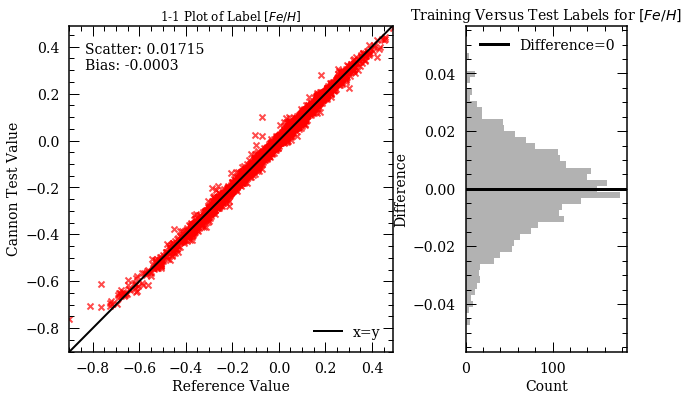

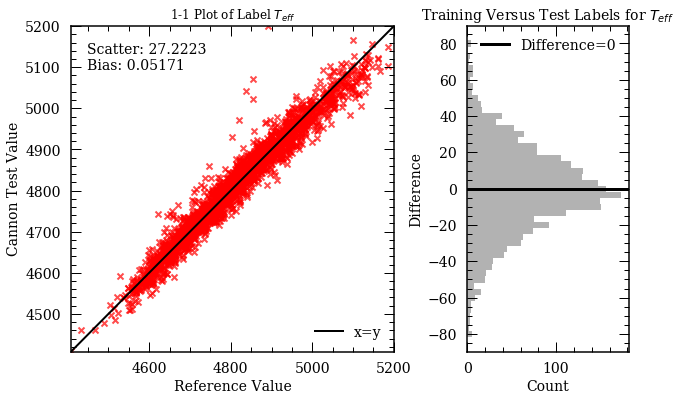

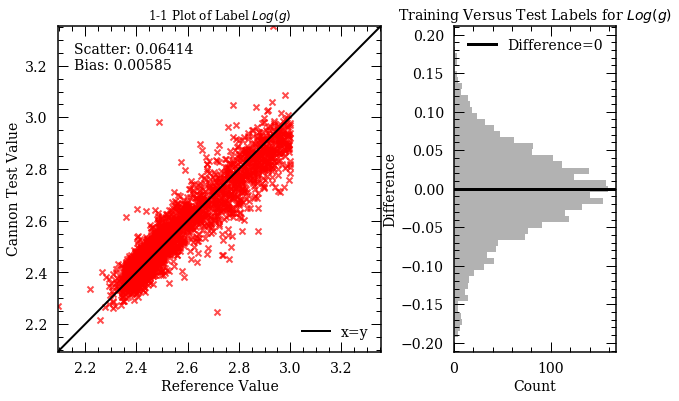

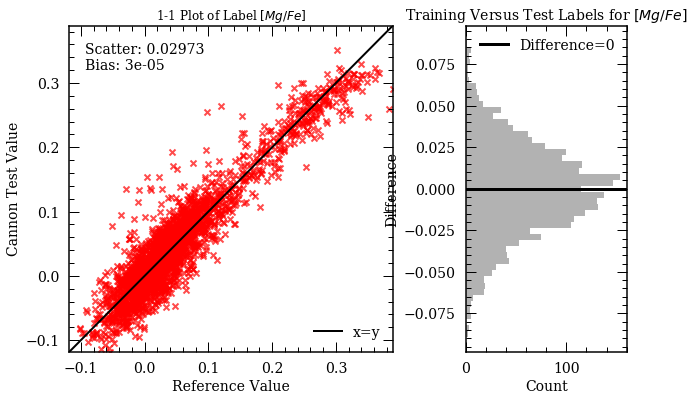

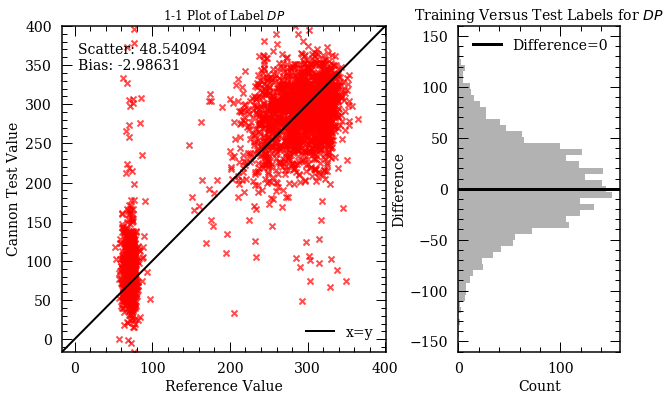

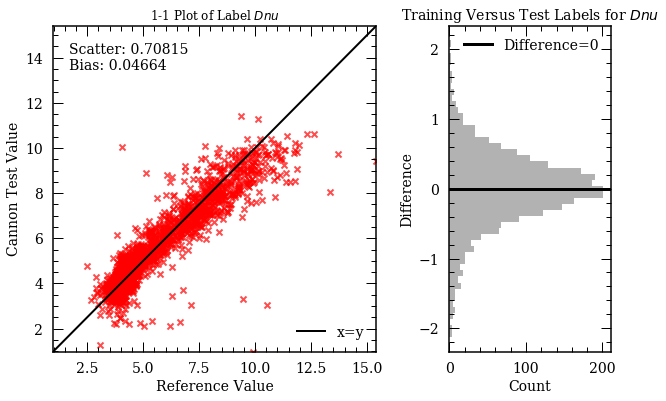

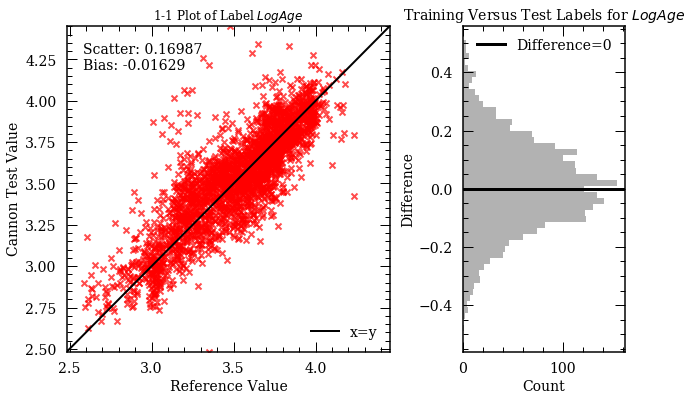

In [131]:
label_names = ds.get_plotting_labels()
nlabels = len(label_names)
print(nlabels)
for i in range(nlabels):
    name = label_names[i]
    orig = reference_labels[:,i]
    cannon = test_labels[:,i]
    
    # calculate bias and scatter
    scatter = np.round(np.std(orig-cannon),5)
    bias  = np.round(np.mean(orig-cannon),5)

    low = np.minimum(min(orig), min(cannon))
    high = np.maximum(max(orig), max(cannon))

    fig = plt.figure(figsize=(10,6))
    gs = gridspec.GridSpec(1,2,width_ratios=[2,1], wspace=0.3)
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    ax1.plot([low, high], [low, high], 'k-', linewidth=2.0, label="x=y")
    ax1.set_xlim(low, high)
    ax1.set_ylim(low, high)
    ax1.legend(fontsize=14, loc='lower right')

    pl = ax1.scatter(orig, cannon, marker='x', c='r',
            vmin=50, vmax=200, alpha=0.7)
    #cb = plt.colorbar(pl, ax=ax1, orientation='horizontal')
    #cb.set_label('SNR from Test Set', fontsize=12)
    textstr = 'Scatter: %s \nBias: %s' %(scatter, bias)
    ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes,
                    fontsize=14, verticalalignment='top')
    ax1.tick_params(axis='x', labelsize=14)
    ax1.tick_params(axis='y', labelsize=14)
    ax1.set_xlabel("Reference Value", fontsize=14)
    ax1.set_ylabel("Cannon Test Value", fontsize=14)
    ax1.set_title("1-1 Plot of Label " + r"$%s$" % name)
    diff = cannon-orig
    npoints = len(diff)
    mu = np.mean(diff)
    sig = np.std(diff)
    #ax2.hist(diff, orientation='horizontal')
    ax2.hist(diff, range=[-3*sig,3*sig], color='k', bins=int(np.sqrt(npoints)),
                    orientation='horizontal', alpha=0.3, histtype='stepfilled')
    ax2.tick_params(axis='x', labelsize=14)
    ax2.tick_params(axis='y', labelsize=14)
    ax2.set_xlabel("Count", fontsize=14)
    ax2.set_ylabel("Difference", fontsize=14)
    ax2.axhline(y=0, c='k', lw=3, label='Difference=0')
    ax2.set_title("Training Versus Test Labels for $%s$" %name,
                    fontsize=14)
    ax2.legend(fontsize=14)
    plt.tight_layout()
    #figname_full = "%s_%s.png" %(figname, i)

/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


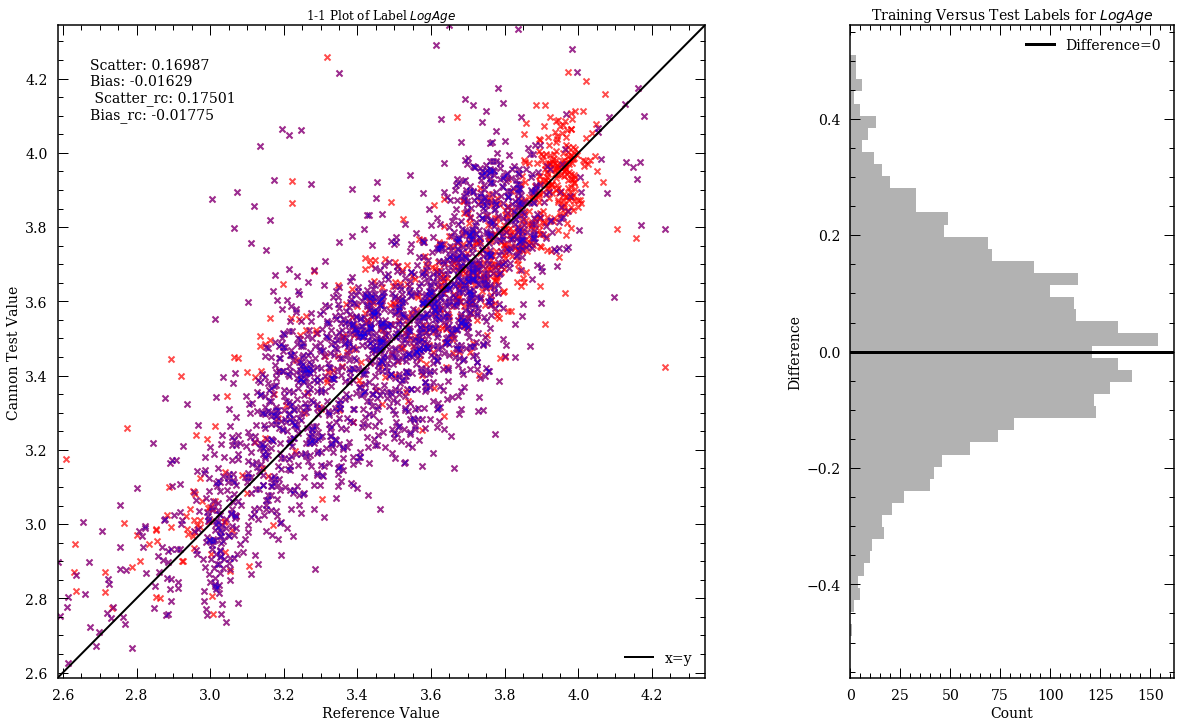

In [142]:
name = label_names[-1]
orig = reference_labels[:,-1]
cannon = test_labels[:,-1]
    
# calculate bias and scatter
scatter = np.round(np.std(orig-cannon),5)
bias  = np.round(np.mean(orig-cannon),5)

low = np.minimum(min(orig), min(cannon))
high = np.maximum(max(orig), max(cannon))

fig = plt.figure(figsize=(20,12))
gs = gridspec.GridSpec(1,2,width_ratios=[2,1], wspace=0.3)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax1.plot([low, high], [low, high], 'k-', linewidth=2.0, label="x=y")
ax1.set_xlim(low, high)
ax1.set_ylim(low, high)
ax1.legend(fontsize=14, loc='lower right')

pl = ax1.scatter(orig, cannon, marker='x', c='r',
            vmin=50, vmax=200, alpha=0.7)

ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_xlabel("Reference Value", fontsize=14)
ax1.set_ylabel("Cannon Test Value", fontsize=14)
ax1.set_title("1-1 Plot of Label " + r"$%s$" % name)
diff = cannon-orig
npoints = len(diff)
mu = np.mean(diff)
sig = np.std(diff)
#ax2.hist(diff, orientation='horizontal')
ax2.hist(diff, range=[-3*sig,3*sig], color='k', bins=int(np.sqrt(npoints)),
                    orientation='horizontal', alpha=0.3, histtype='stepfilled')
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_xlabel("Count", fontsize=14)
ax2.set_ylabel("Difference", fontsize=14)
ax2.axhline(y=0, c='k', lw=3, label='Difference=0')
ax2.set_title("Training Versus Test Labels for $%s$" %name,
                    fontsize=14)
ax2.legend(fontsize=14)


# for RC
name = label_names[-1]
orig = reference_labels[:,-1]
cannon = test_labels[:,-1]

m=reference_labels[:,-3]>230
orig = orig[m]
cannon = cannon[m]

# calculate bias and scatter
scatter_rc = np.round(np.std(orig-cannon),5)
bias_rc  = np.round(np.mean(orig-cannon),5)

low = np.minimum(min(orig), min(cannon))
high = np.maximum(max(orig), max(cannon))

ax1.set_xlim(low, high)
ax1.set_ylim(low, high)
ax1.legend(fontsize=14, loc='lower right')

pl = ax1.scatter(orig, cannon, marker='x', c='b',
            vmin=50, vmax=200, alpha=0.4)

textstr = 'Scatter: %s \nBias: %s \n Scatter_rc: %s \nBias_rc: %s' %(scatter, bias, scatter_rc, bias_rc)
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes,
                    fontsize=14, verticalalignment='top')


ax2.legend(fontsize=14)
plt.tight_layout()



In [130]:
10**4

10000

Train on all data

In [64]:
"""
Ntrain=int(len(tr_label)*0.8)
shuffle_inds = np.arange(len(tr_ID))
np.random.shuffle(shuffle_inds)

train_ID = tr_ID[shuffle_inds[:Ntrain]]
train_flux = tr_flux[shuffle_inds[:Ntrain],:]
train_ivar = tr_ivar[shuffle_inds[:Ntrain],:]
train_label = tr_label[shuffle_inds[:Ntrain],:]

test_ID = tr_ID[shuffle_inds[Ntrain:]]
test_flux = tr_flux[shuffle_inds[Ntrain:],:]
test_ivar = tr_ivar[shuffle_inds[Ntrain:],:]
test_label = tr_label[shuffle_inds[Ntrain:],:]
"""

train_ID = tr_ID
train_flux = tr_flux
train_ivar = tr_ivar
train_label = tr_label

test_ID = tr_ID
test_flux = tr_flux
test_ivar = tr_ivar
test_label = tr_label

In [65]:
from TheCannon import dataset
#from importlib import reload  
#reload(dataset)

ds = dataset.Dataset(wl, train_ID, train_flux, train_ivar, train_label, 
                     test_ID, test_flux, test_ivar, test_label)


Loading dataset
This may take a while...


In [66]:
ds.set_label_names(['[Fe/H]','T_{eff}','Log(g)','[Mg/Fe]','D P','D nu','LogAge'])



Diagnostic for SNRs of reference and survey objects


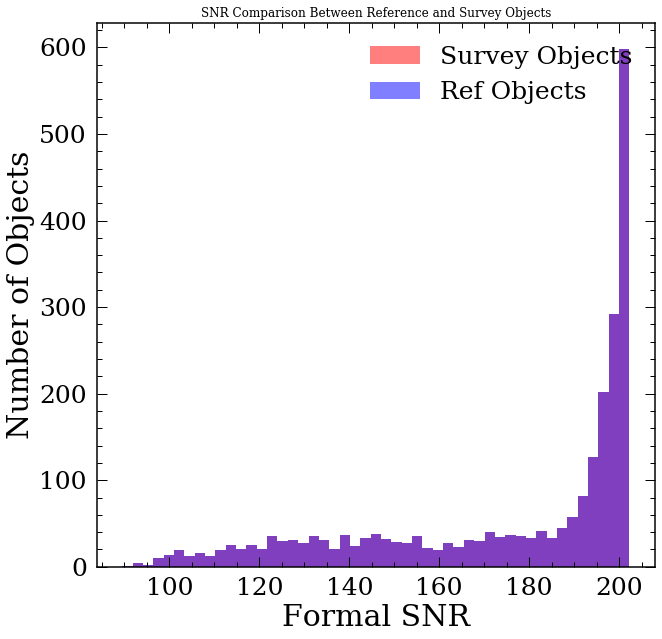

In [67]:
fig = ds.diagnostics_SNR()



Plotting every label against every other


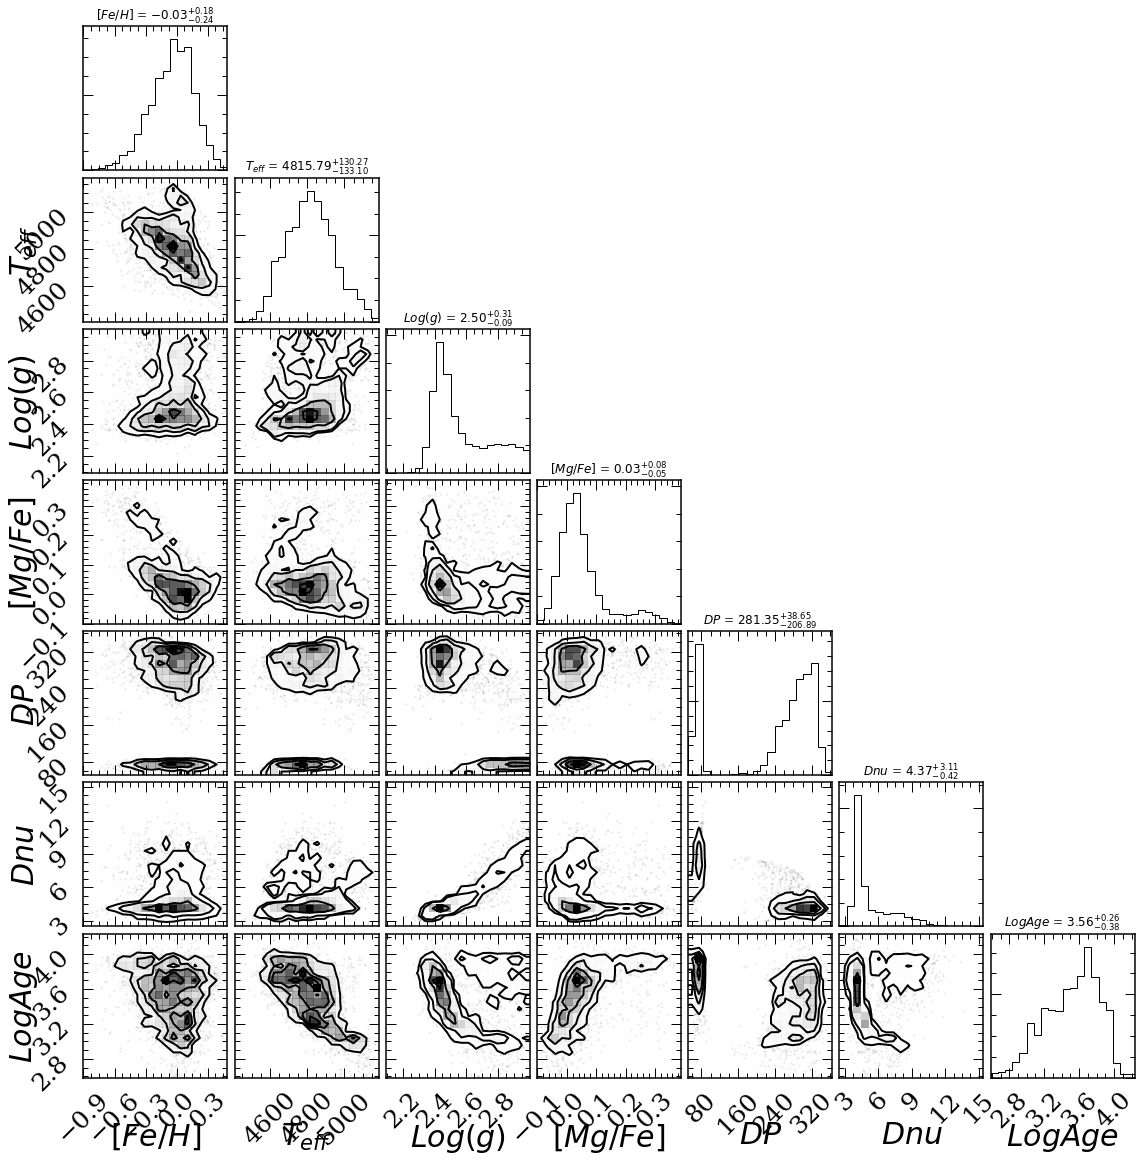

In [68]:
fig = ds.diagnostics_ref_labels()

In [69]:
#from importlib import reload  
#reload(model)

In [70]:
from TheCannon import model
md = model.CannonModel(2, useErrors=False)
md.fit(ds)

<TheCannon.model.CannonModel object at 0x124d11cc0> <TheCannon.dataset.Dataset object at 0x12483f898>
Done training model. 


In [71]:
#md.diagnostics_contpix(ds)


Diagnostic plot: leading coeffs and scatters across wavelength.


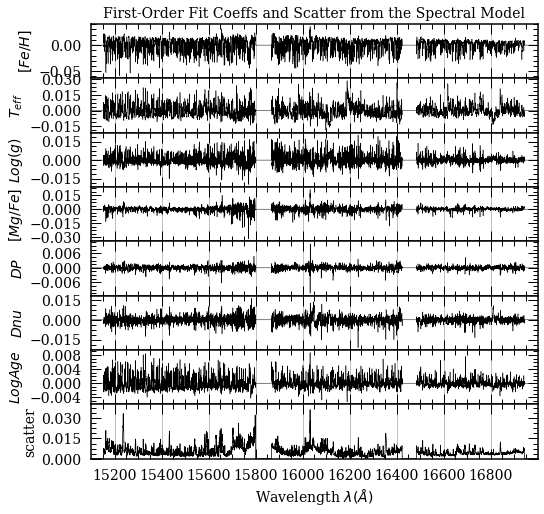

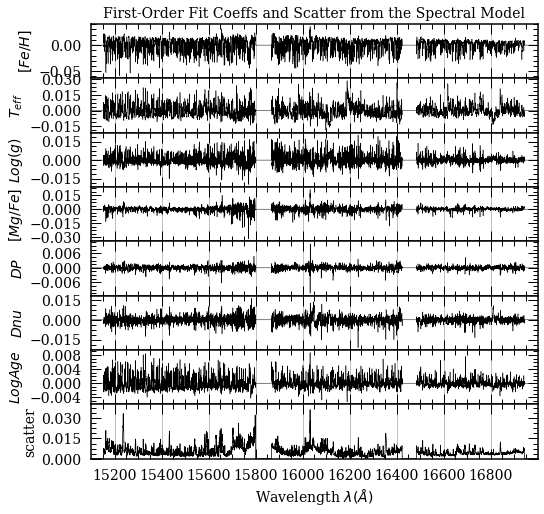

In [72]:
md.diagnostics_leading_coeffs(ds)


In [73]:
md.diagnostics_plot_chisq(ds)

Diagnostic plot: histogram of the red chi squareds of the fit
Saved as modelfit_chisqs.png


In [74]:
label_errs = md.infer_labels(ds)

Inferring Labels


In [75]:
test_labels = ds.test_label_vals

In [76]:
ds.diagnostics_test_step_flagstars()

Reference label [Fe/H]
flagged 111 stars beyond 2-sig of ref labels
Saved list flagged_stars_0.txt
Reference label T_{eff}
flagged 104 stars beyond 2-sig of ref labels
Saved list flagged_stars_1.txt
Reference label Log(g)
flagged 101 stars beyond 2-sig of ref labels
Saved list flagged_stars_2.txt
Reference label [Mg/Fe]
flagged 202 stars beyond 2-sig of ref labels
Saved list flagged_stars_3.txt
Reference label D P
flagged 76 stars beyond 2-sig of ref labels
Saved list flagged_stars_4.txt
Reference label D nu
flagged 160 stars beyond 2-sig of ref labels
Saved list flagged_stars_5.txt
Reference label LogAge
flagged 122 stars beyond 2-sig of ref labels
Saved list flagged_stars_6.txt


Plotting every label against every other


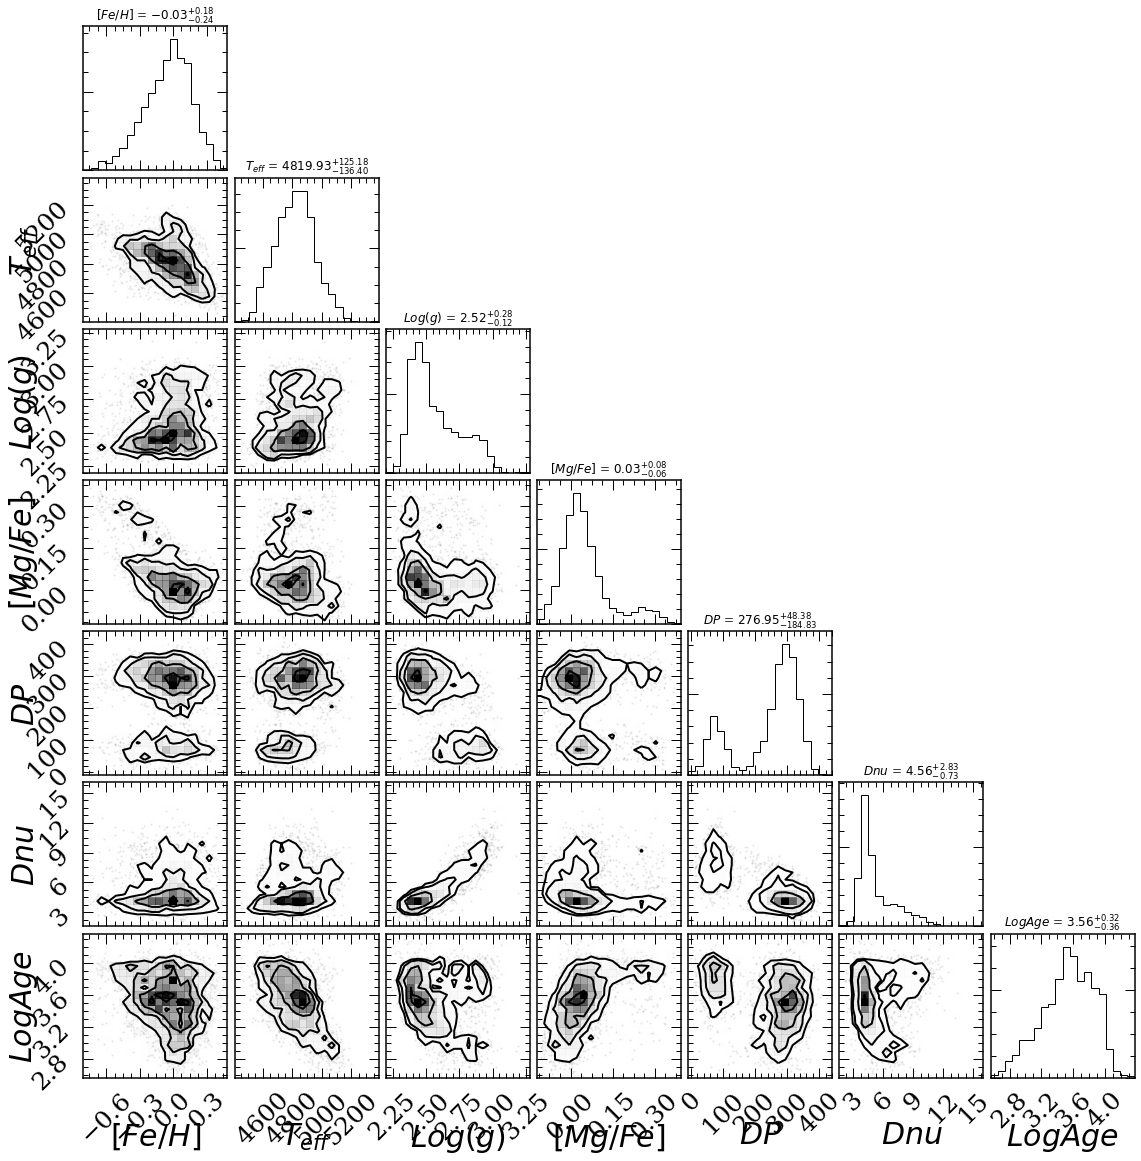

In [77]:
ds.diagnostics_survey_labels()

In [78]:
ds.tr_label=test_label

7


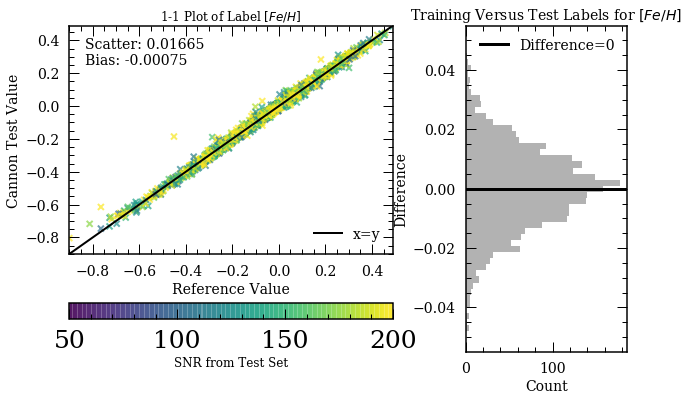

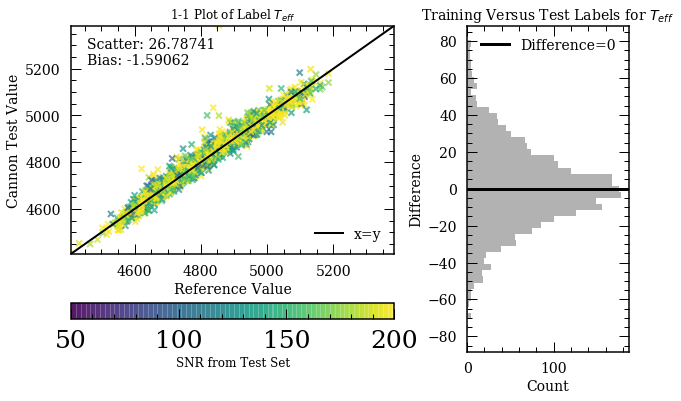

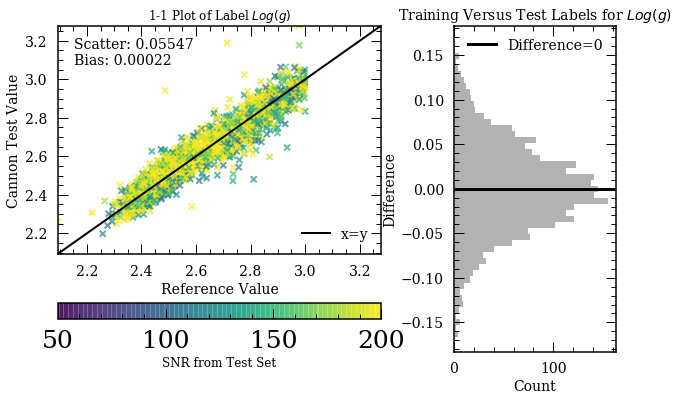

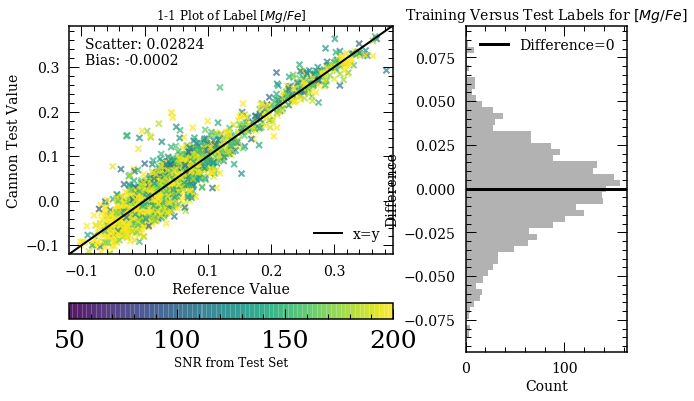

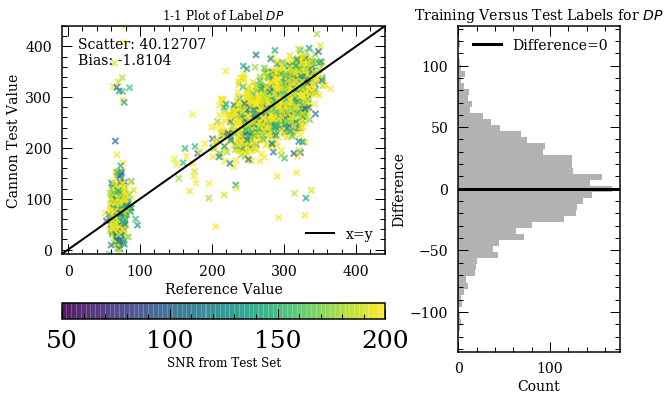

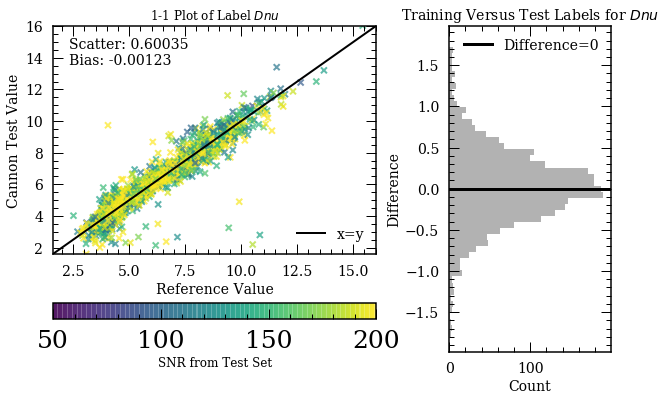

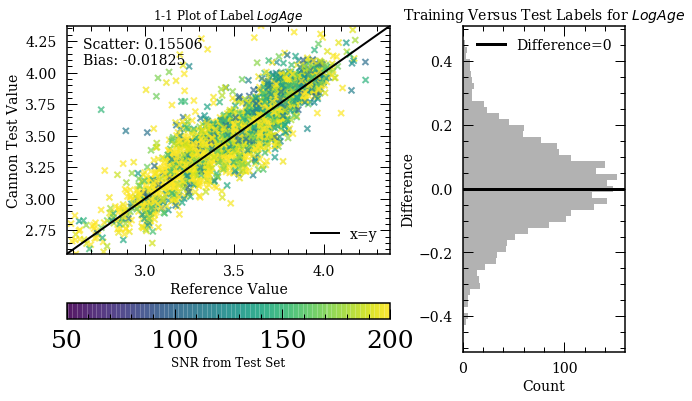

In [79]:
# with more stars 
diagnostics_1to1(ds)

7


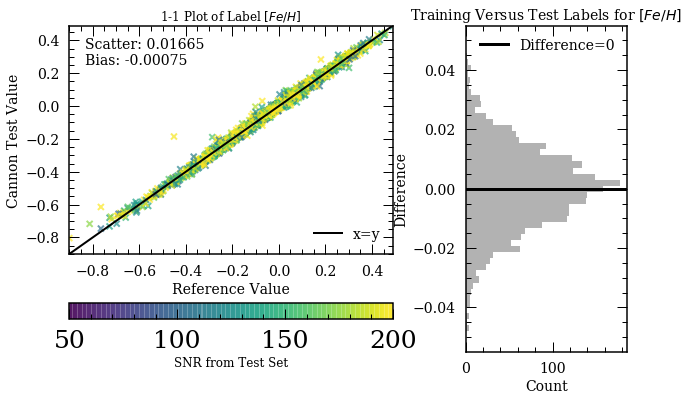

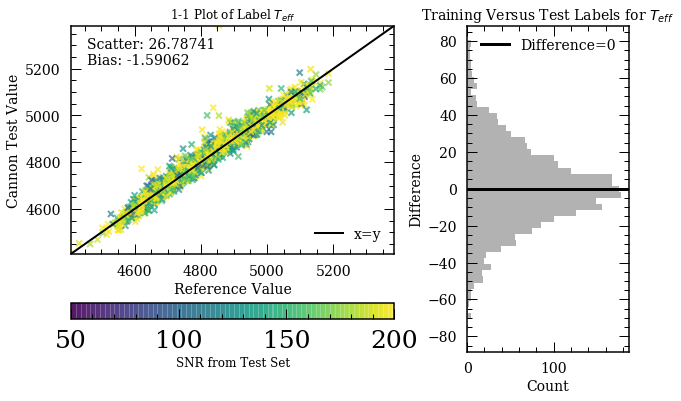

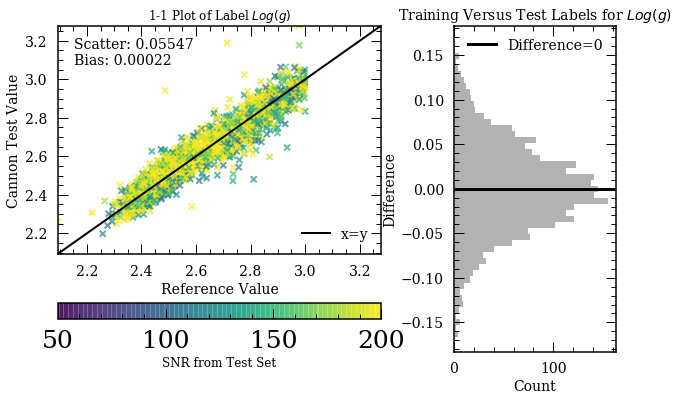

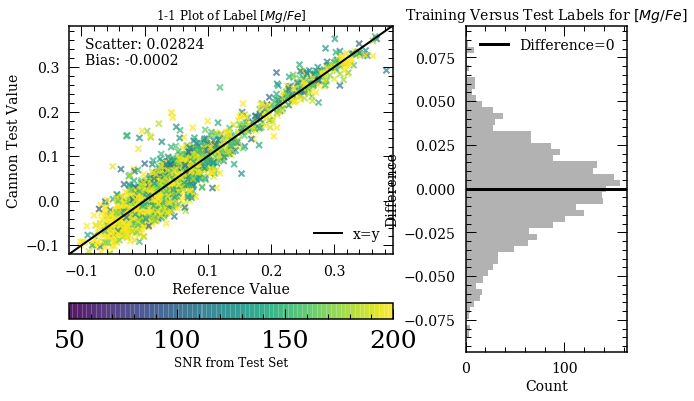

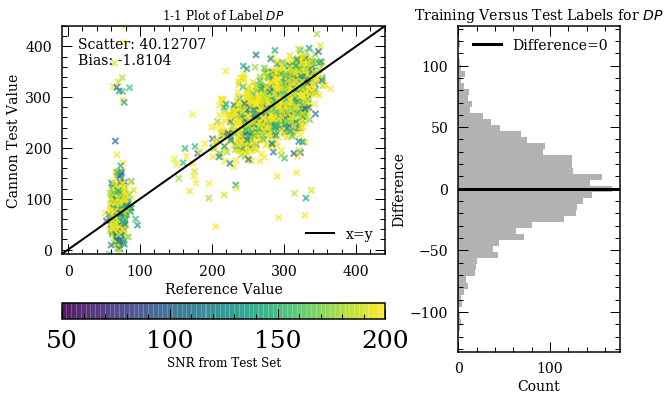

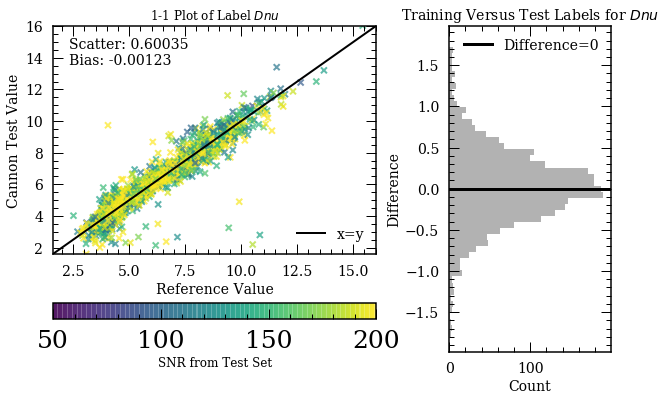

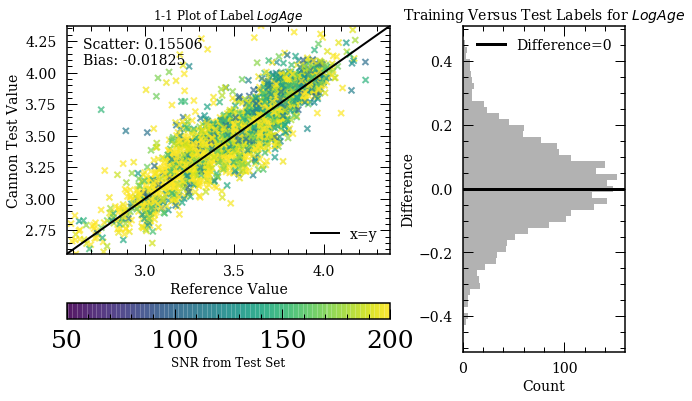

In [80]:
# no flags
diagnostics_1to1(ds)

Text(0.5, 1.0, 'Testing set')

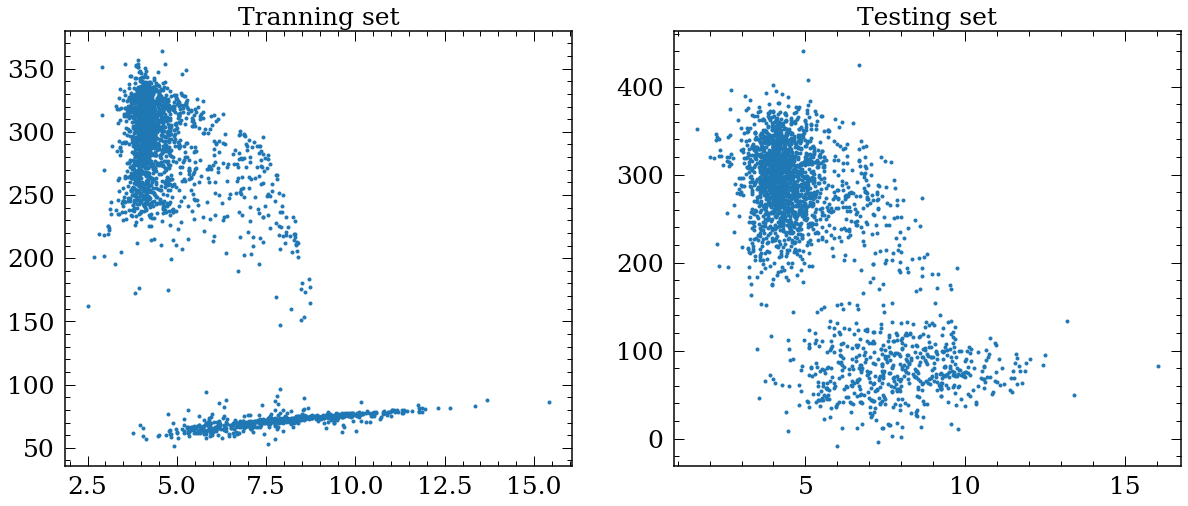

In [81]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(ds.test_label[:,5],ds.test_label[:,4],'.')
plt.title('Tranning set',fontsize=25)
plt.subplot(1,2,2)
plt.plot(ds.test_label_vals[:,5],ds.test_label_vals[:,4],'.')
plt.title('Testing set',fontsize=25)

# Calculate red clump contamination rate (13.0%)

In [83]:
allstars=pd.DataFrame(np.array((np.array(ds.test_ID),np.array(ds.test_label_vals[:,5]),np.array(ds.test_label_vals[:,4]))).T,
                      columns=['ID','Dnu','DP'])


In [84]:
print(len(allstars))
allstars=pd.merge(allstars,pd.read_pickle('Vrard2016_CM.pkl')[['APOGEE_ID','Status']],left_on='ID',right_on='APOGEE_ID',how='inner').drop_duplicates(subset='ID',keep='first')
print(len(allstars))

2480
2480


In [116]:
allstars['Dnu']=np.array([float(i) for i in allstars['Dnu']])
allstars['DP']=np.array([float(i) for i in allstars['DP']])

#m1=allstars['Dnu']>3
#m2=allstars['Dnu']<5.5
m3=allstars['DP']>230
m4=allstars['DP']<370

m=m1&m2&m3&m4

No handles with labels found to put in legend.


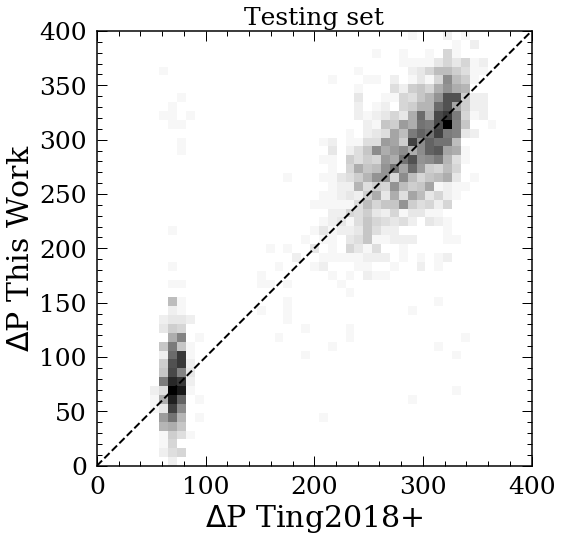

In [117]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,2)
xedges = np.linspace(0,400,50)
yedges = np.linspace(0,400,50)
#plt.plot(ds.test_label[:,4],allstars['DP'],'r.',label='Vrard+2016',alpha=0.5)
H, xedges, yedges = np.histogram2d(ds.test_label[:,4],allstars['DP'], bins=(xedges, yedges))
H = H.T
plt.imshow(1-H, interpolation='nearest', origin='low',extent=[0, 400, 0, 400],cmap='gray')
#plt.plot(ds.test_label[:,4][m],allstars['DP'][m],'.',label='this work')
plt.plot([0,400],[0,400],'k--')
plt.title('Testing set',fontsize=25)
plt.xlabel('$\Delta$P Ting2018+')
plt.ylabel('$\Delta$P This Work')
plt.xlim([0,400])
plt.ylim([0,400])
plt.legend()



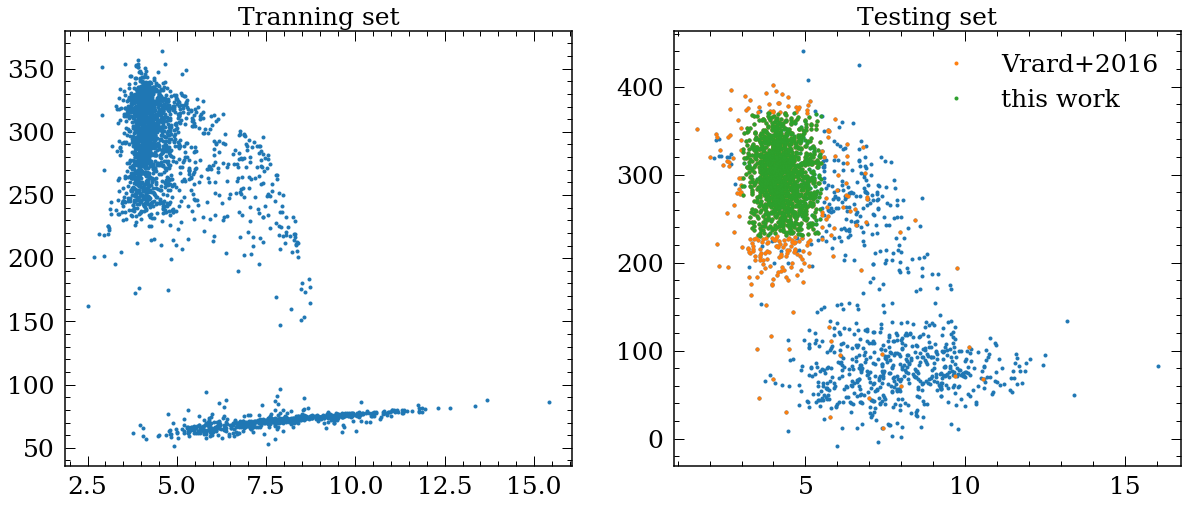

In [118]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(ds.test_label[:,5],ds.test_label[:,4],'.')
rcstars=allstars.loc[allstars['Status']==1]


plt.title('Tranning set',fontsize=25)
plt.subplot(1,2,2)
plt.plot(ds.test_label_vals[:,5],ds.test_label_vals[:,4],'.')
plt.plot(rcstars['Dnu'],rcstars['DP'],'.',label='Vrard+2016')
plt.plot(allstars['Dnu'][m],allstars['DP'][m],'.',label='this work')
plt.title('Testing set',fontsize=25)
plt.legend()


In [283]:
allstars['stage_cannon']=np.zeros(len(allstars),dtype=bool)
allstars['stage_cannon'].loc[m]=1


/Users/lucy/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [284]:
predict=allstars.loc[allstars['stage_cannon']==1]

real=predict['Status'].values

corrects=np.zeros(len(predict),dtype=bool)

for i in range(len(predict)):
    if predicts[i]==real[i]:
        corrects[i]=1

 

In [285]:
1-sum(corrects)/len(predict)

0.12848402447314755

In [125]:
check=230
# from ting
positives=allstars['DP']>check
netavies=ds.test_label[:,4]<check

cross=positives&netavies

cont=sum(cross)/sum(positives)

In [126]:
cont

0.026635784597568036